## Data Preparation
**By Lorena Dorado & Parisa Kamizi**

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import re
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import warnings
warnings.filterwarnings('ignore')

# Download necessary NLTK resources (only needed once)
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

# web scraping
import requests
from bs4 import BeautifulSoup
import re
from urllib.parse import urlparse
import time
import datetime
import logging
import os
from pytz import timezone
import random

In [2]:
# Original data
df = pd.read_excel('recalls_details.xlsx')

## EDA

In [3]:
# Display basic information about the dataset
print("\nDataset Information:")
print(f"Shape: {df.shape}")
print("\nColumn names:")
print(df.columns.tolist())


Dataset Information:
Shape: (95082, 17)

Column names:
['FEI Number', 'Recalling Firm Name', 'Product Type', 'Product Classification', 'Status', 'Distribution Pattern', 'Recalling Firm City', 'Recalling Firm State', 'Recalling Firm Country', 'Center Classification Date', 'Reason for Recall', 'Product Description', 'Event ID', 'Event Classification', 'Product ID', 'Center', 'Recall Details']


In [4]:
# Display first few rows
print("\nFirst 5 rows:")
print(df.head())


First 5 rows:
   FEI Number        Recalling Firm Name    Product Type  \
0     2016693  Arizona Foods Group, Inc.  Food/Cosmetics   
1  3012966183              Tyber Medical         Devices   
2  3012966183              Tyber Medical         Devices   
3  3012966183              Tyber Medical         Devices   
4  3012966183              Tyber Medical         Devices   

  Product Classification     Status              Distribution Pattern  \
0                Class I  Completed  Domestic distribution within NV.   
1               Class II    Ongoing                        Nationwide   
2               Class II    Ongoing                        Nationwide   
3               Class II    Ongoing                        Nationwide   
4               Class II    Ongoing                        Nationwide   

  Recalling Firm City Recalling Firm State Recalling Firm Country  \
0             Phoenix              Arizona          United States   
1           Bethlehem         Pennsylvania     

Data Overview and Summary Statistics

In [5]:
print("\nData types:")
print(df.dtypes)
print("\nMissing values by column:")
print(df.isnull().sum())


Data types:
FEI Number                            object
Recalling Firm Name                   object
Product Type                          object
Product Classification                object
Status                                object
Distribution Pattern                  object
Recalling Firm City                   object
Recalling Firm State                  object
Recalling Firm Country                object
Center Classification Date    datetime64[ns]
Reason for Recall                     object
Product Description                   object
Event ID                               int64
Event Classification                  object
Product ID                             int64
Center                                object
Recall Details                        object
dtype: object

Missing values by column:
FEI Number                    0
Recalling Firm Name           0
Product Type                  0
Product Classification        0
Status                        0
Distribution Pattern 

Target Variable Analysis


Target Variable (Event Classification) Distribution:
Event Classification
Class II     67325
Class I      20111
Class III     7646
Name: count, dtype: int64

Percentage distribution:
Event Classification
Class II     70.807303
Class I      21.151217
Class III     8.041480
Name: count, dtype: float64


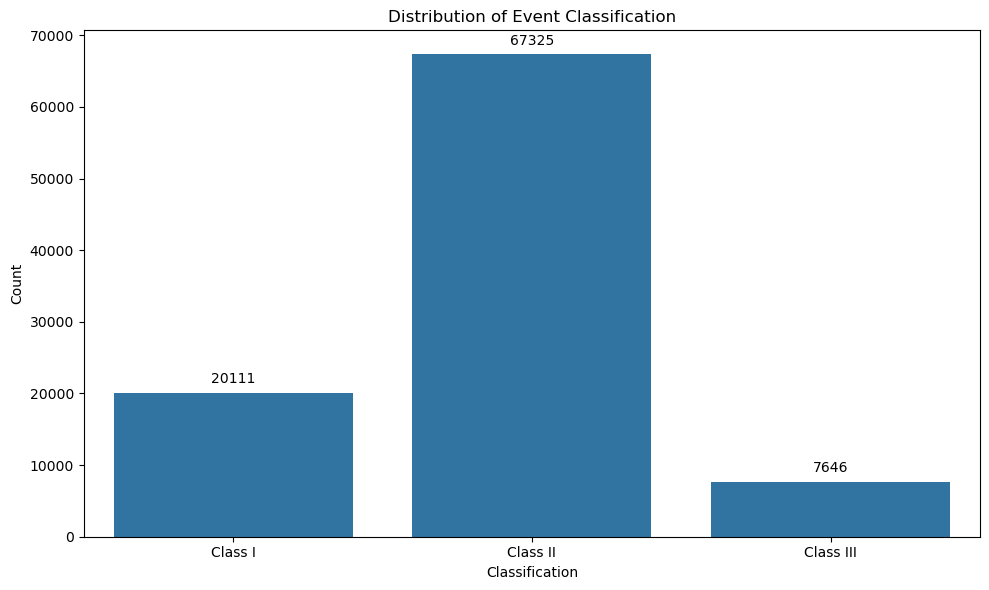

In [6]:
print("\nTarget Variable (Event Classification) Distribution:")
target_counts = df['Event Classification'].value_counts()
print(target_counts)
print("\nPercentage distribution:")
print(target_counts / len(df) * 100)

# Plot target distribution
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='Event Classification', data=df)
plt.title('Distribution of Event Classification')
plt.xlabel('Classification')
plt.ylabel('Count')

# Add count labels on bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 10), 
                textcoords='offset points')

plt.tight_layout()
plt.savefig('event_classification_distribution.png')

Feature Analysis for Independent Variables

In [7]:
# Categorical Features
categorical_features = ['Product Type', 'Status', 'Recalling Firm State', 'Recalling Firm Country']

for feature in categorical_features:
    print(f"\nDistribution of {feature}:")
    value_counts = df[feature].value_counts().head(10)  # Top 10 values
    print(value_counts)


Distribution of Product Type:
Product Type
Devices           35475
Food/Cosmetics    27435
Drugs             16702
Biologics         12051
Veterinary         3410
Tobacco               9
Name: count, dtype: int64

Distribution of Status:
Status
Terminated    80276
Ongoing       13151
Completed      1655
Name: count, dtype: int64

Distribution of Recalling Firm State:
Recalling Firm State
California       10104
Illinois          6308
Florida           6216
New Jersey        5096
Pennsylvania      4559
New York          4494
Massachusetts     4367
-                 4331
Texas             4322
Ohio              3562
Name: count, dtype: int64

Distribution of Recalling Firm Country:
Recalling Firm Country
United States     90751
Canada              911
Germany             416
United Kingdom      282
China               280
Switzerland         278
Israel              248
Japan               223
India               209
Netherlands         205
Name: count, dtype: int64


Date Feature

In [8]:
# Convert Center Classification Date to datetime
df['Center Classification Date'] = pd.to_datetime(df['Center Classification Date'], errors='coerce')

# Extract temporal features
df['Classification Year'] = df['Center Classification Date'].dt.year
df['Classification Month'] = df['Center Classification Date'].dt.month
df['Classification Day'] = df['Center Classification Date'].dt.day
df['Classification DayOfWeek'] = df['Center Classification Date'].dt.dayofweek

Text Features

In [9]:
# Define function for basic text cleaning
def clean_text(text):
    if not isinstance(text, str):
        return ""
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove special characters, digits, and extra spaces
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\d+', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    
    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    return ' '.join(tokens)

# Apply text cleaning to text columns
text_features = ['Reason for Recall', 'Product Description']
for feature in text_features:
    print(f"\nProcessing {feature}...")
    df[f'{feature}_cleaned'] = df[feature].apply(clean_text)
    
    # Display sample of original and cleaned text
    print("\nSample of original and cleaned text:")
    sample_idx = np.random.randint(0, len(df))
    print(f"Original: {df.loc[sample_idx, feature][:200]}...")
    print(f"Cleaned: {df.loc[sample_idx, f'{feature}_cleaned'][:200]}...")


Processing Reason for Recall...

Sample of original and cleaned text:
Original: Product may contain undeclared milk....
Cleaned: product may contain undeclared milk...

Processing Product Description...

Sample of original and cleaned text:
Original: Apheresis Platelets, Leukocytes Reduced, Irradiated...
Cleaned: apheresis platelet leukocyte reduced irradiated...


URL Feature

In [10]:
# Extract domain and check if URL is accessible
df['Has_Recall_URL'] = df['Recall Details'].notna() & df['Recall Details'].str.contains('http', case=False, na=False)

Handle Missing Values

In [11]:
# For categorical features, fill with 'Unknown'
for feature in categorical_features:
    df[feature] = df[feature].fillna('Unknown')

# For text features, fill with empty string
for feature in text_features:
    df[feature] = df[feature].fillna('')
    df[f'{feature}_cleaned'] = df[f'{feature}_cleaned'].fillna('')

Feature Selection for Dataset

In [12]:
# Select features to use in the model
selected_features = [
    # Categorical features
    'Product Type', 
    'Status', 
    'Recalling Firm State', 
    'Recalling Firm Country',
    
    # Temporal features
    'Classification Year',
    'Classification Month',
    'Classification Day',
    'Classification DayOfWeek',
    
    # Text features (cleaned)
    'Reason for Recall_cleaned',
    'Product Description_cleaned',
    
    # URL feature
    'Has_Recall_URL'
]

# Target variable
target = 'Event Classification'

# Remove rows with missing target values
print(f"\nRows before removing missing target values: {len(df)}")
df = df.dropna(subset=[target])
print(f"Rows after removing missing target values: {len(df)}")


Rows before removing missing target values: 95082
Rows after removing missing target values: 95082


Create final dataset

In [13]:
final_data = df[selected_features + [target]].copy()

# Display information about the final dataset
print("\nFinal Dataset Information:")
print(f"Shape: {final_data.shape}")
print(f"Columns: {final_data.columns.tolist()}")
print("\nSample rows from final dataset:")
print(final_data.head())

# Save the processed data to CSV
final_data.to_csv('fda_recalls_processed.csv', index=False)
print("\nProcessed data saved to 'fda_recalls_processed.csv'")


Final Dataset Information:
Shape: (95082, 12)
Columns: ['Product Type', 'Status', 'Recalling Firm State', 'Recalling Firm Country', 'Classification Year', 'Classification Month', 'Classification Day', 'Classification DayOfWeek', 'Reason for Recall_cleaned', 'Product Description_cleaned', 'Has_Recall_URL', 'Event Classification']

Sample rows from final dataset:
     Product Type     Status Recalling Firm State Recalling Firm Country  \
0  Food/Cosmetics  Completed              Arizona          United States   
1         Devices    Ongoing         Pennsylvania          United States   
2         Devices    Ongoing         Pennsylvania          United States   
3         Devices    Ongoing         Pennsylvania          United States   
4         Devices    Ongoing         Pennsylvania          United States   

   Classification Year  Classification Month  Classification Day  \
0                 2025                     2                  21   
1                 2025                    

Web Scraping for more recall information

# References
An, J. (2024). Structural topic modeling for corporate social responsibility of food supply chain management: evidence from FDA recalls on plant-based food products. Social Responsibility Journal, 20(6), 1089–1100. https://www-emerald-com.sandiego.idm.oclc.org/insight/content/doi/10.1108/srj-07-2023-0412/full/html https://doi.org/10.1108/SRJ-07-2023-0412​

Barbosa Slivinskis, V., Agi Maluli, I., & Seth Broder, J. (2025). A Machine Learning Algorithm to Predict Medical Device Recall by the Food and Drug Administration. The Western Journal of Emergency Medicine, 26(1), 161–170. https://escholarship.org/uc/item/4sd03611 https://doi.org/10.5811/westjem.21238​

Dubin, J. R., Simon, S. D., Norrell, K., Perera, J., Gowen, J., & Cil, A. (2021). Risk of Recall Among Medical Devices Undergoing US Food and Drug Administration 510(k) Clearance and Premarket Approval, 2008-2017. JAMA Network Open, 4(5), e217274–e217274.https://jamanetwork.com/journals/jamanetworkopen/fullarticle/2779577 https://doi.org/10.1001/jamanetworkopen.2021.7274​

OpenAI. (2025). Response on how to cite ChatGPT in APA 7. ChatGPT (GPT-4). https://openai.com

Polisena, J., Jutai, J., & Chreyh, R. (2014). A proposed framework to improve the safety of medical devices in a Canadian hospital context. Medical Devices: Evidence and Research, 7, 139–147.​

Qiao, P. (2024). Bayesian Algorithm for The Construction of Logistics Node Delay Model and Its Impact on Subsequent Nodes in Supply Chain. Journal of Electrical Systems, 20(3), 386–394. https://doi.org/10.52783/jes.2861​

Zhou, Y. (2023). The effects of lobbying on the FDA’s recall classification. BMC Medical Ethics, 24(1), 41–41. https://doi.org/10.1186/s12910-023-00921-0​

An, Y. (2024). The impact of supply chain analysis on recall effectiveness. Journal of Supply Chain Management, 60(1), 12-23. https://onlinelibrary.wiley.com/doi/10.1111/jscm.12306​